In [ ]:
import os
from pathlib import Path
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
from plotting_Toellke import *
from read_results_1 import *
from scipy import signal

file_path: Path = Path(os.getcwd()).resolve()
eeg_folder: Path = file_path / "eeg_files"


In [126]:
eeg_data: Dict[str, np.ndarray] = {}

for file in eeg_folder.iterdir():
    if file.is_file() and file.suffix == ".txt" and "sleep" in file.name:
        data = np.loadtxt(file)                                # Carga cada array
        name = file.stem.replace("input_nonepi_", "")          # e.g. "sleep_1"
        eeg_data[name] = data - data.mean()

# 2. Ordenar los canales para garantizar consistencia
channel_names = sorted(eeg_data.keys())                     # ['sleep_1','sleep_2','sleep_3']

# 3. Apilar verticalmente en un array 2D (n_canales, n_muestras)
# data_2d = np.vstack([eeg_data[ch] for ch in channel_names])  # Utiliza np.vstack :contentReference[oaicite:3]{index=3}

# 4. Crear el objeto Info
sfreq = 1024.0                                             # Frecuencia de muestreo en Hz (ajusta si es distinto)
# ch_types = ['eeg'] * len(channel_names)
# info = mne.create_info(ch_names=channel_names,             # Nombres de canal
#                        sfreq=sfreq,
#                        ch_types=ch_types)                  # create_info :contentReference[oaicite:4]{index=4}

# 5. Construir el RawArray
# raw = mne.io.RawArray(data_2d, info)                      # RawArray :contentReference[oaicite:5]{index=5}
# print(raw)
# print(raw.info)

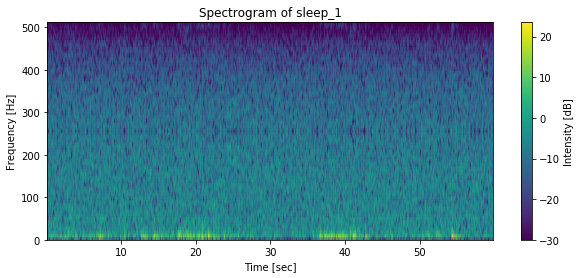

In [127]:
# Compute the spectrogram for the first channel (e.g., 'sleep_1')
f, t, Sxx = signal.spectrogram(eeg_data["sleep_1"], fs=sfreq, nperseg=128)

# Plot the spectrogram in dB scale
plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', vmin=-30)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of sleep_1')
plt.colorbar(label='Intensity [dB]')
# plt.ylim(0, 20)
plt.show()

In [128]:
# Generamos ruido blanco gaussiano
eeg_files_noise: Dict[str, np.ndarray] = {}
for key in eeg_data.keys():
    sd = eeg_data[key].std()*.01
    mu = eeg_data[key].mean()
    noise = np.random.normal(mu, sd, size=eeg_data[key].shape)
    eeg_files_noise[key] = eeg_data[key] + noise

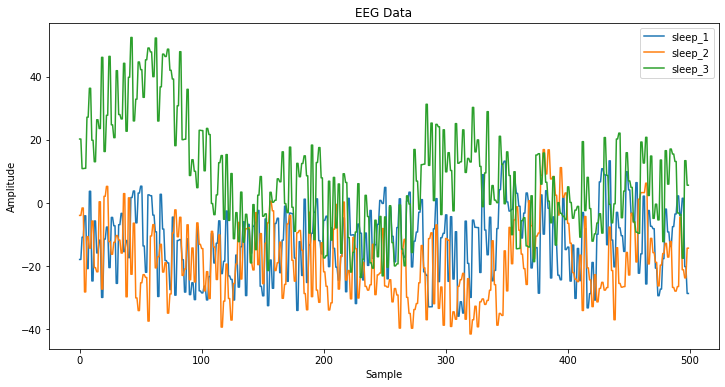

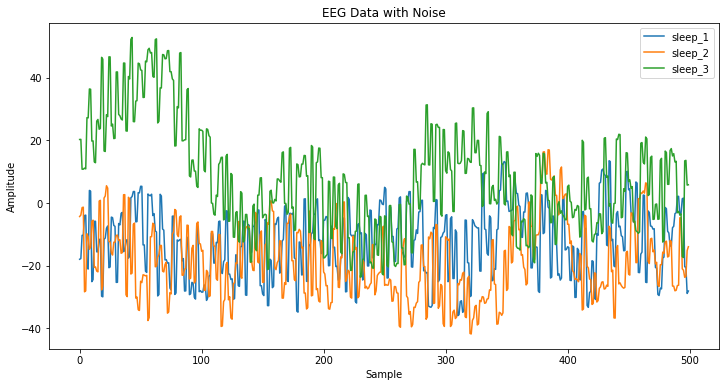

In [129]:
# Representamos sin ruido
plt.figure(figsize=(12, 6))
for name in channel_names:
    plt.plot(eeg_data[name][:500], label=name)
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("EEG Data")
plt.legend()
plt.show()

# Representamos con ruido
plt.figure(figsize=(12, 6))
for name in channel_names:
    plt.plot(eeg_files_noise[name][:500], label=name)
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("EEG Data with Noise")
plt.legend()
plt.show()

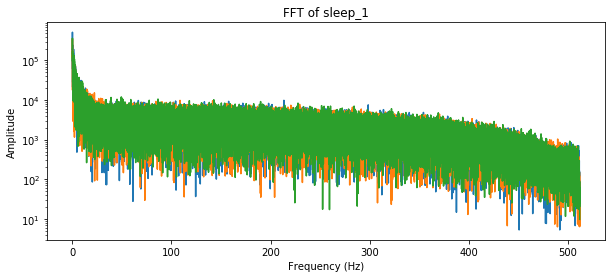

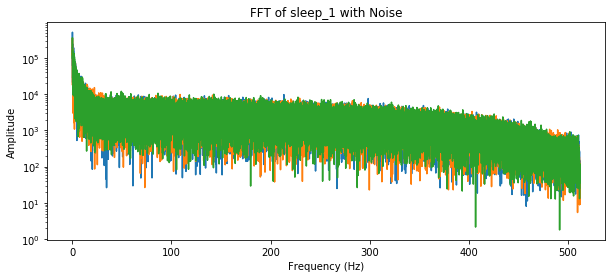

In [130]:
# Representamos sin ruido
plt.figure(figsize=(10, 4))
for name, data in eeg_data.items():
    fft_vals = np.fft.fft(data)
    n = len(data)
    freq = np.fft.fftfreq(n, 1/sfreq)

    # Select only the non-negative frequencies
    idx = freq >= 0

    plt.plot(freq[idx][1:], np.abs(fft_vals)[idx][1:])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title(f"FFT of {name}")
    plt.yscale("log")
plt.show()

# Representamos con ruido
plt.figure(figsize=(10, 4))
for name, data in eeg_files_noise.items():
    fft_vals = np.fft.fft(data)
    n = len(data)
    freq = np.fft.fftfreq(n, 1/sfreq)

    # Select only the non-negative frequencies
    idx = freq >= 0

    plt.plot(freq[idx][1:], np.abs(fft_vals)[idx][1:])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title(f"FFT of {name} with Noise")
    plt.yscale("log")
plt.show()

In [131]:
# Guardamos los arhcivos con ruido en la carpeta eeg_files como .txt
eeg_noise_folder: Path = file_path / "eeg_files_noise"
eeg_noise_folder.mkdir(exist_ok=True, parents=True)  # Crea la carpeta si no existe

for key, value in eeg_files_noise.items():
    file_name = f"input_nonepi_{key}_noise_soft.txt"
    file_noise_path = eeg_noise_folder / file_name
    np.savetxt(file_noise_path, value, fmt='%.6f')
    print(f"Saved {file_name} with noise.")

Saved input_nonepi_sleep_2_noise_soft.txt with noise.
Saved input_nonepi_sleep_3_noise_soft.txt with noise.
Saved input_nonepi_sleep_1_noise_soft.txt with noise.


In [132]:
def gaussian_pulse(fs: float, t: np.ndarray, f_carrier: float, amp: float, center: float, sigma: float) -> np.ndarray:
    """
    Generate a Gaussian-modulated sinusoidal pulse.
    
    Parameters
    ----------
    fs : float
        Sampling frequency.
    t : np.ndarray
        Time vector.
    f_carrier : float
        Carrier frequency.
    amp : float
        Amplitude of the pulse.
    center : float
        Center frequency of the Gaussian envelope.
    sigma : float
        Standard deviation of the Gaussian envelope.
    
    Returns
    -------
    np.ndarray
        The generated Gaussian-modulated sinusoidal pulse.
    """
    envelope = np.exp(-0.5 * ((t - center) / sigma) ** 2)
    carrier = amp/2 * np.sin(2 * np.pi * f_carrier * t)
    pulse = envelope * carrier
    
    return pulse

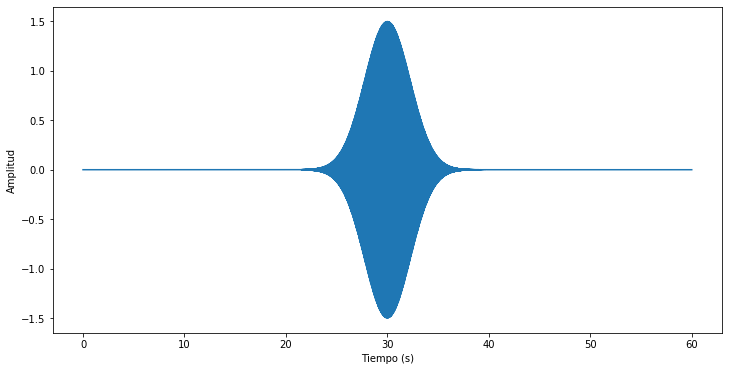

In [133]:
import numpy as np
import matplotlib.pyplot as plt

fs = 1024                        # Frecuencia de muestreo (Hz)
t = np.arange(0, 60, 1/fs)      # Vector de tiempo de 50 ms
f_rf = 200                        # Frecuencia de la portadora RF (Hz)
amplitud = 3.0                    # Amplitud del pulso

# Envolvente gaussiana centrada en 25 ms, de anchura (sigma) ~5 ms
centro_pulso = 30 # 25 ms
sigma = 5**.5

pulso_rf = gaussian_pulse(fs, t, f_rf, amplitud, centro_pulso, sigma)

plt.figure(figsize=(12, 6))
plt.plot(t, pulso_rf)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.show()


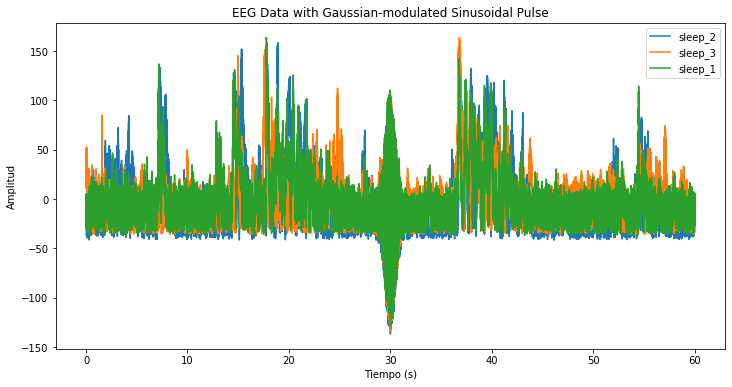

In [134]:
plt.figure(figsize=(12, 6))
for key, value in eeg_data.items():
    amp = (value.max() - value.min())
    f_carrier = 200
    center = 30
    sigma = .5
    pulse = gaussian_pulse(fs, t, f_carrier, amp, center, sigma)
    
    modified_eeg = value + pulse
    
    plt.plot(t, modified_eeg, label=key)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("EEG Data with Gaussian-modulated Sinusoidal Pulse")
plt.legend()
plt.show()

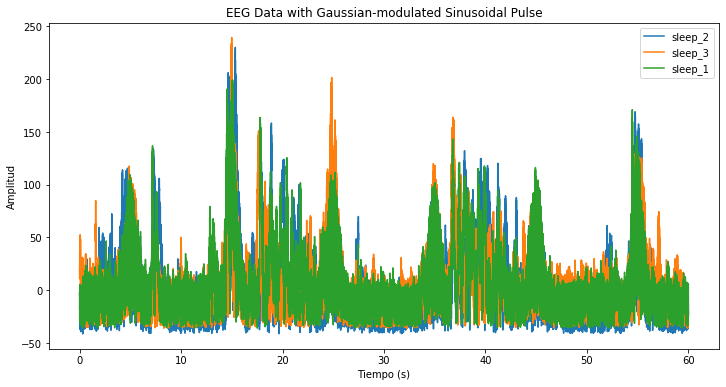

Saved input_nonepi_sleep_2_gaussian.txt with Gaussian-modulated pulse.
Saved input_nonepi_sleep_3_gaussian.txt with Gaussian-modulated pulse.
Saved input_nonepi_sleep_1_gaussian.txt with Gaussian-modulated pulse.


In [135]:
eeg_data_gaussian: Dict[str, np.ndarray] = {}
for key, value in eeg_data.items():
    amp = (value.max() - value.min())
    f_carrier = 200
    sigma = .5
    modulated_rf = 0
    centers = np.arange(5, 60, 10)
    for center in centers:
        pulse = gaussian_pulse(fs, t, f_carrier, amp, center, sigma)
        modulated_rf += pulse
    
    modified_eeg = value + np.abs(modulated_rf)
    eeg_data_gaussian[key] = modified_eeg

plt.figure(figsize=(12, 6))
for key, value in eeg_data_gaussian.items():   
    plt.plot(t, eeg_data_gaussian[key], label=key)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("EEG Data with Gaussian-modulated Sinusoidal Pulse")
plt.legend()
plt.show()

# Guardamos los arhcivos con ruido en la carpeta eeg_files como .txt
eeg_gaussian_folder: Path = file_path / "eeg_files_noise"
eeg_gaussian_folder.mkdir(exist_ok=True, parents=True)  # Crea la carpeta si no existe
for key, value in eeg_data_gaussian.items():
    file_name = f"input_nonepi_{key}_gaussian.txt"
    file_gaussian_path = eeg_gaussian_folder / file_name
    np.savetxt(file_gaussian_path, value, fmt='%.6f')
    print(f"Saved {file_name} with Gaussian-modulated pulse.")

In [ ]:
LFP_noise_1_path = file_path.parent / "results" / "results_noise_1" / "LFP.txt"

True